# Temporal pattern analysis

'''Created on Tue Sep 01 2020'''

In this notebook we will analyze the temporal patterns of neural activity in the three conditions.


In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
import scipy
from sklearn.decomposition import PCA
cmap = cm.jet
import math

In [2]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 56165           ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 10                 ## value of resampling
session_now = 1
period = 6
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!
if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        if mouse == 32364:
            fixed = 'LR'
        if mouse == 56165:
            fixed = 'UR'
    else:
        if session_now == 2:
            task = 'STABLE'
            if mouse == 32364:
                fixed = 'UL and UR'
            if mouse == 56165:
                fixed = 'UR and LR (verify)'
        else:
            task = 'RANDOM'
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            
if mouse == 32366:
    sessions = [3,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'

In [3]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/scoring_time_vector/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/data/process/figures/temporal_analysis/'

In [4]:
# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
day = 1
for trial in [1,6,11,16,21]:
    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                          '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.1.npy'

    ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = sstats.zscore(neural_activity1)
    
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                        re_sf=re_sf)
    
    activity_list.append(resample_neural_activity_mean)
    
    time_file_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{1}' + \
                          '.' + f'{0}' + '_10.pkl'
    timeline_file = open(timeline_file_dir + time_file_session_1, 'rb')
    timeline_info = pickle.load(timeline_file)
    ##normalize neural activity
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = activity.shape[1]
    resample_timeline = timeline_1/re_sf

    timeline_list.append(resample_timeline)
    
    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' +'_day_'+f'{day}'+'_event_' + f'{re_sf}' + '.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    #c = np.linspace(0, 20, len(behaviour))
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
    resample_timeline = timeline_1/re_sf
    
    behaviour_list.append(resample_beh1)
    day = day + 1

In [5]:
# for each day creates a list that counts and saves times of different events.
# We will consider events here as resting period, navigation periods and object exploration periods.
# Later on will also consider different objects in the exploration periods

events_day_list = []
events_counter_day_list = []
events_time_starts_day = []
for day in range(len(behaviour_list)):
    events_list = []
    events_counter_list = []
    events_time_starts = []
    start_counter = 100
    counter = 0
    for i in range(behaviour_list[day].shape[0]):
        if behaviour_list[day][i] != start_counter:
            events_list.append(start_counter)
            events_counter_list.append(counter)
            events_time_starts.append(i)
            start_counter = behaviour_list[day][i]
            counter = 1
        else:
            counter = counter + 1
    events_day_list.append(events_list)
    events_counter_day_list.append(events_counter_list)
    events_time_starts_day.append(events_time_starts)

In [6]:
# separte events belonging to each of the behavioural conditions

behavioural_events_days_list = []
conditions = [ 'Resting', 'Navigation', 'Object_exploration']

for day in range(len(behaviour_list)):
    events = np.array(events_day_list[day])
    events[np.where(events>1)] = 2
    events_counter = np.array(events_counter_day_list[day])
    events_time = np.array(events_time_starts_day[day])

    object_list = []
    for target in [0,1,2]:
        object_data = []
        position_events = np.where(events == target)[0]
        events_duration = events_counter[position_events]   # convert to seconds
        time = events_time[position_events]
        i = 0
        for event in events_duration:
            if event > period:
                object_data.append(activity_list[day][:,time[i]:time[i]+period])
            i = i + 1
        object_list.append(object_data)
    behavioural_events_days_list.append(object_list)

In [7]:
population_vector = []
for day in range(len(behaviour_list)):
    mean_over_trials_list = []
    for i in range(len(behavioural_events_days_list[day])):
        mean_over_trials= np.mean(behavioural_events_days_list[day][i], axis= 0)
        if mean_over_trials.shape:
            mean_over_trials_list.append(np.mean(mean_over_trials,axis=1))
    population_vector.append(mean_over_trials_list)

/home/melisa/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/melisa/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [32]:
### compute activity matrix to use for entire correlations matrix across time
matrix = []
corr = []
corr_noise = []
pca_data = []
explained_variance = []
pca = PCA(n_components=6)

for day in range(len(behavioural_events_days_list)):
    corr_matrix_list = []
    corr_matrix_noise_list = []
    matrix_list = []
    pca_list = []
    variance = []
    for i in range(len(behavioural_events_days_list[day])):
        if behavioural_events_days_list[day][i]: 
            
            mean_over_trials =  np.mean(behavioural_events_days_list[day][i], axis= 0)
            mean_firing_rate = np.mean(mean_over_trials, axis = 1)
            positions = np.flip(np.argsort(mean_firing_rate))
            new_mean_over_trials = mean_over_trials[positions,:]
            non_zero_positions = np.where(np.mean(new_mean_over_trials,axis=1))
            non_zero_mean_over_trials = new_mean_over_trials[non_zero_positions,:]
            non_zero_mean_over_trials = non_zero_mean_over_trials [0,:,:]
            mean_over_trials_list.append(non_zero_mean_over_trials)

            positions1 = positions[np.where(mean_firing_rate[positions])]
            
            matrix1 = np.zeros((positions1.shape[0],period*len(behavioural_events_days_list[day][i])))
            matrix2 = np.zeros((positions1.shape[0],period*len(behavioural_events_days_list[day][i])))
            
            for j in range(len(behavioural_events_days_list[day][i])):
                matrix1[:,j*period:(j+1)*period] = behavioural_events_days_list[day][i][j][positions1,:]
                matrix2[:,j*period:(j+1)*period] = behavioural_events_days_list[day][i][j][positions1,:] - mean_over_trials[positions1,:]
            
            pca.fit(matrix1)
            x = pca.components_
            
            matrix_list.append(matrix1)
            corr_matrix = stats.corr_matrix(neural_activity = matrix1.T)
            corr_matrix_list.append(corr_matrix)
            corr_matrix_noise = stats.corr_matrix(neural_activity = matrix2.T)
            corr_matrix_noise_list.append(corr_matrix_noise)
            
            pca_list.append(x)
            variance.append(pca.explained_variance_ratio_)
            
    matrix.append(matrix_list)
    corr.append(corr_matrix_list)
    corr_noise.append(corr_matrix_noise_list)
    pca_data.append(pca_list)
    explained_variance.append(variance)

(6, 24)
(6, 252)
(6, 174)
(6, 24)
(6, 246)
(6, 156)
(6, 24)
(6, 180)
(6, 174)
(6, 24)
(6, 204)
(6, 168)
(6, 30)
(6, 42)


/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


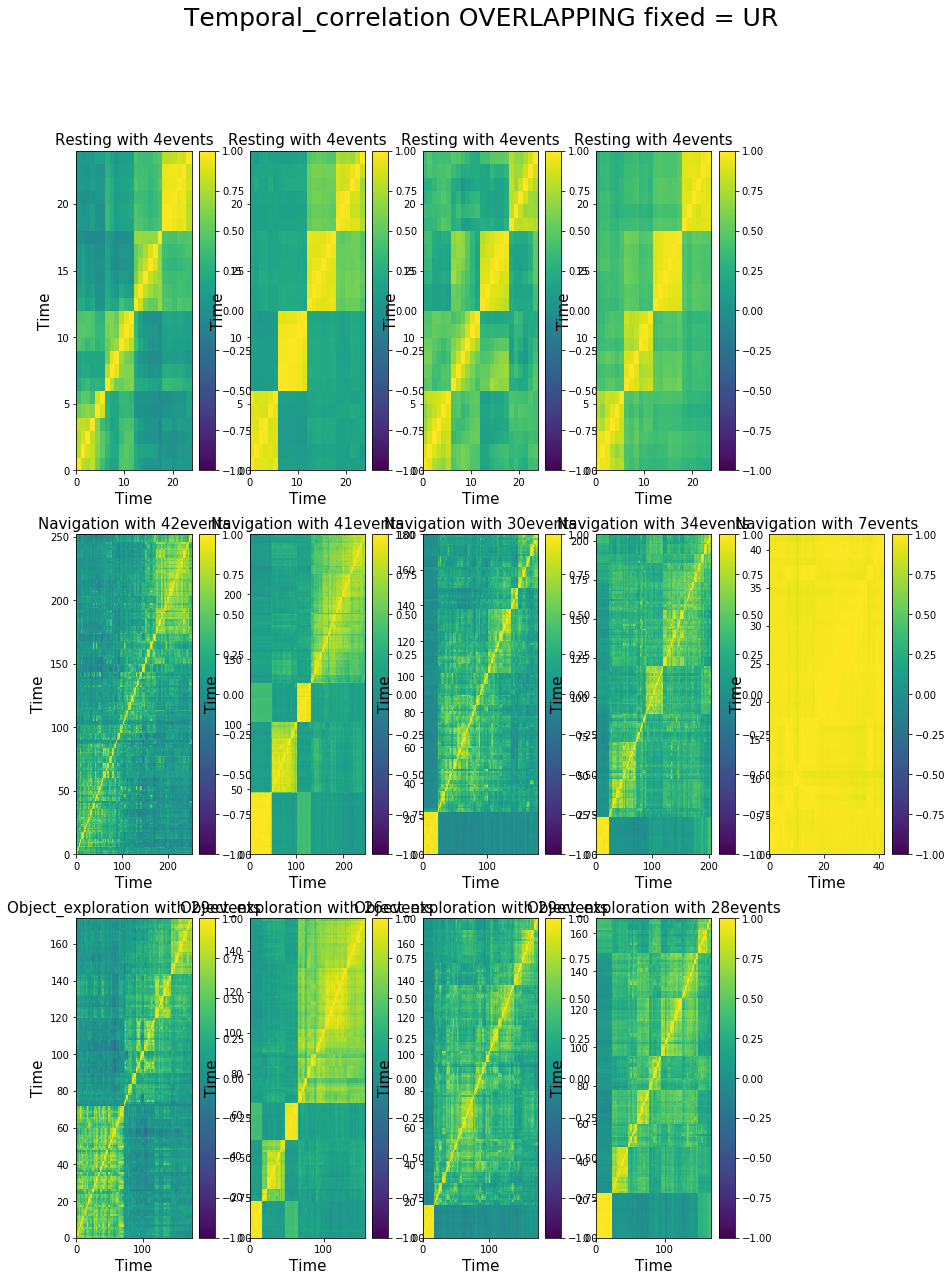

In [33]:
import matplotlib as m

cdict = {
  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
}
cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

vmin_corr= -1
vmax_corr=1
fig = plt.figure()
gs = plt.GridSpec(3, 5)

i=0
for day in range(len(matrix)):
    for j in range(len(matrix[day])):
        if behavioural_events_days_list[day][j]: 
            ax = fig.add_subplot(gs[j,day])
            
            ax.set_ylabel('Time', fontsize = 15)
            ax.set_xlabel('Time', fontsize = 15)
            ax.set_title(conditions[j] + ' with ' + f'{int(matrix[day][j].shape[1]/period)}' + 'events' , fontsize = 15)

            mesh = ax.pcolormesh(corr[day][j], cmap = 'viridis')
            mesh.set_clim(vmin_corr,vmax_corr)
            fig.colorbar(mesh,ax=ax)

            
fig.tight_layout()
fig.set_size_inches(15,20)

fig.suptitle('Temporal_correlation '+ task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'temporal_pattern_correlation_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)

In [34]:
pca_data[0][0][0]

array([0.12038479, 0.13960166, 0.12171455, 0.13479141, 0.09773846,
       0.09144729, 0.19185118, 0.16349877, 0.12519914, 0.17811512,
       0.18006807, 0.17899421, 0.2277506 , 0.22198219, 0.21306525,
       0.18485659, 0.19920937, 0.18704779, 0.29477097, 0.29194938,
       0.28279164, 0.28922731, 0.28475365, 0.25980635])

/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Text(0.5, 0.98, 'temporal_pca OVERLAPPING fixed = UR')

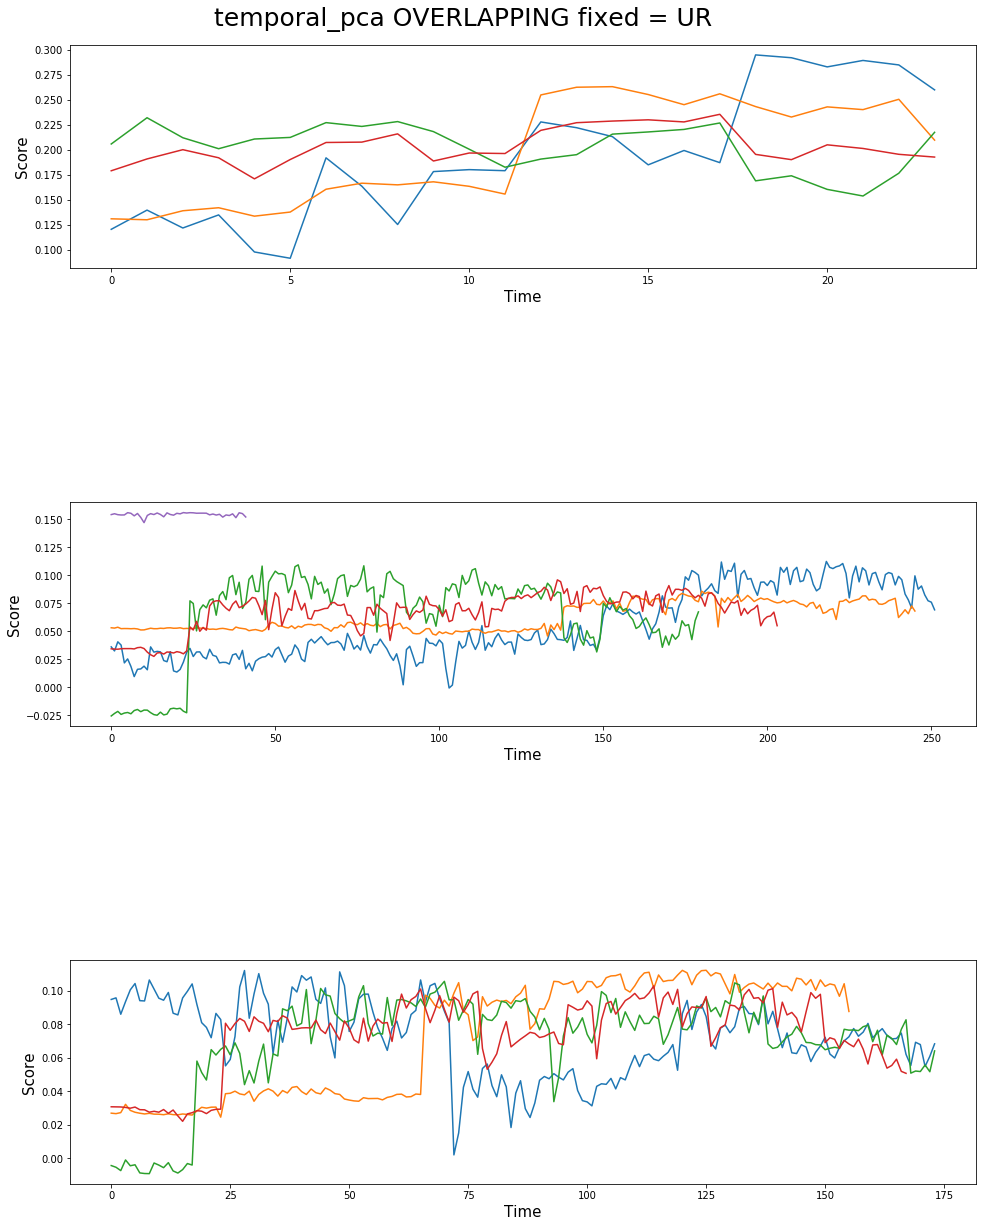

In [36]:
fig = plt.figure()
gs = plt.GridSpec(3,1)

i=0
for day in range(len(matrix)):
    for j in range(len(matrix[day])):
        if behavioural_events_days_list[day][j]: 
            ax = fig.add_subplot(gs[j,0])
            
            ax.set_ylabel('Score', fontsize = 15)
            ax.set_xlabel('Time', fontsize = 15)
            ax.plot(pca_data[day][j][0])
        
            
fig.tight_layout()
fig.set_size_inches(15,20)

fig.suptitle('temporal_pca '+ task + ' fixed = ' + fixed  , fontsize = 25)


/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Text(0.5, 0.98, 'temporal_pca OVERLAPPING fixed = UR')

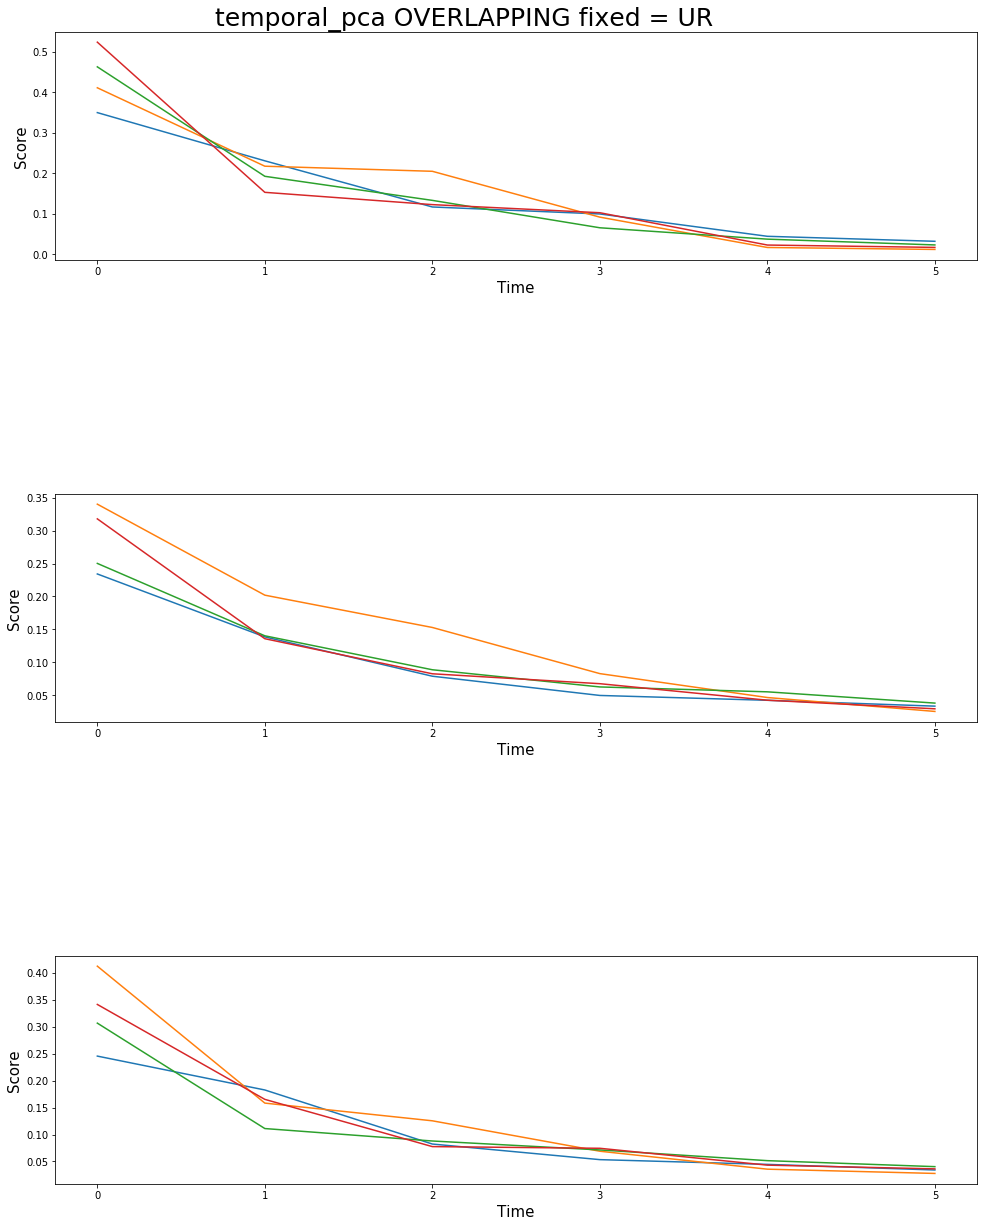

In [39]:
fig = plt.figure()
gs = plt.GridSpec(3,1)

i=0
for day in range(len(matrix)-1):
    for j in range(len(matrix[day])):
        if behavioural_events_days_list[day][j]: 
            ax = fig.add_subplot(gs[j,0])
            
            ax.set_ylabel('Score', fontsize = 15)
            ax.set_xlabel('Time', fontsize = 15)
            ax.plot(explained_variance[day][j])
        
            
fig.tight_layout()
fig.set_size_inches(15,20)

fig.suptitle('temporal_pca '+ task + ' fixed = ' + fixed  , fontsize = 25)
